# 風管四 105308045 林庭萱


# 更動的部分：
1. encoder層數改為(128,100,2)
2. decoder層數改為(2,100,128)
3. batch size改為 650
4. 訓練次數 10 次
5. 第一次訓練時loss rate 為-0.7 圖形為一條直線
   之後改成-0.6 圖形則較為接近平均分布

# 01 導入套件

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

# 02 下載並整理資料集

In [41]:
# 載入資料集
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# 調整資料大小
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

# 03 建立VAE模型

In [159]:
##建立encoder層
x = Input(shape=(784,))

enc_1 = Dense(128, activation='sigmoid')
enc_2 = Dense(100, activation='sigmoid')
enc_3 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var=Dense(2)

# Define latent repre. of x
z = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(z)
z_log_var = enc_log_var(z)

z_input = Input(shape = (2,))





In [160]:
## 抽樣

def sampling(a):
    z_mean, z_log_var = a
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [147]:
z = Lambda(sampling, output_shape = (2,))([z_mean, z_log_var])

In [161]:
##建立decoder層

dec_3 = Dense(100, activation='sigmoid')
dec_2 = Dense(128, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(dec_3(z)))

In [162]:
## 建立模型

In [163]:
VAE = Model(x, x_hat)
VAE.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_200 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_201 (Dense)            (None, 100)               12900     
_________________________________________________________________
dense_202 (Dense)            (None, 2)                 202       
_________________________________________________________________
dense_205 (Dense)            (None, 100)               300       
_________________________________________________________________
dense_206 (Dense)            (None, 128)               12928     
_________________________________________________________________
dense_207 (Dense)            (None, 784)               101

# 04 建立loss函數

In [164]:
reconstruction_loss = 784 * losses.binary_crossentropy(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.6##-0.6
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

# 05 訓練VAE 

In [167]:
VAE.compile(optimizer=Adam())

In [168]:
VAE.fit(X_train, 
        batch_size=650, ##512
        epochs=10) ##訓練10次

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 212us/sample - loss: 258.7743
Epoch 2/10
60000/60000 [==============================] - 10s 174us/sample - loss: 207.3398
Epoch 3/10
60000/60000 [==============================] - 5s 90us/sample - loss: 206.6386
Epoch 4/10
60000/60000 [==============================] - 4s 73us/sample - loss: 206.4146
Epoch 5/10
60000/60000 [==============================] - 5s 85us/sample - loss: 206.2913
Epoch 6/10
60000/60000 [==============================] - 5s 79us/sample - loss: 206.2421
Epoch 7/10
60000/60000 [==============================] - 5s 89us/sample - loss: 206.0942
Epoch 8/10
60000/60000 [==============================] - 5s 88us/sample - loss: 205.8264
Epoch 9/10
60000/60000 [==============================] - 6s 99us/sample - loss: 205.3662
Epoch 10/10
60000/60000 [==============================] - 7s 111us/sample - loss: 204.5263


# 06 encoder視覺化

In [169]:
VAE_encoder = Model(x, z_mean)
VAE_encoder.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_200 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_201 (Dense)            (None, 100)               12900     
_________________________________________________________________
dense_202 (Dense)            (None, 2)                 202       
_________________________________________________________________
dense_203 (Dense)            (None, 2)                 6         
Total params: 113,588
Trainable params: 113,588
Non-trainable params: 0
_________________________________________________________________


In [170]:
indices = np.random.randint(X_train.shape[0], size = 5000)
VAE_latents = VAE_encoder.predict(X_train[indices])

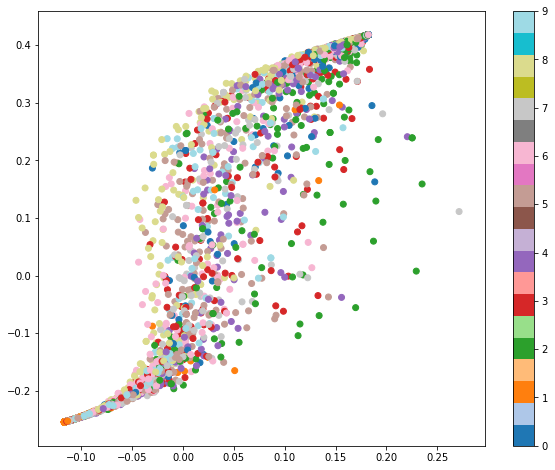

In [171]:
plt.figure(figsize = (10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c = y_train0[indices], cmap = 'tab20')
plt.colorbar()
plt.show()